### INTERCOMPARISON DATA

In [1]:
f_meisei  = '/scratch/das/federico/INTERCOMPARISON_MAURITIUS/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc'
f_vaisala = '/scratch/das/federico/INTERCOMPARISON_MAURITIUS/0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc'

In [2]:
import h5py as h5
import pandas as pd
import numpy as np
from tqdm import tqdm
import os,sys
    
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
def read(file):
    h = h5.File(file, 'r')
    ot = h['observations_table']
    ht = h['header_table']
    d = {}
    var = ['date_time','z_coordinate', 'z_coordinate_type', 'observed_variable', 'observation_value'   ]
    for v in var:
        if v =='date_time':
            vv = pd.to_datetime( ot[v][:], unit='s',  origin=pd.Timestamp('1900-01-01') )
            
            # apparently there is a 4 hour offset between MEISEI and VAISALA
            # we consider the VAISALA as the correct one
            # we adjust the MEISEI by subracting 4 hours
            
            if 'meisei' in file:  # apparently there is a 4 hour offset between MEISEI and VAISALA
                delta = pd.Timedelta(hours=4)
                vv = vv - delta
                
        else:
            vv = ot[v][:]
        d[v] = vv
    print("Creating the dataframe ::: ") 
    df = pd.DataFrame.from_dict( d )
    df['z_coordinate'] = df['z_coordinate'].astype(float)
    print("Created the dataframe ::: ") 
    
    ts = ht['report_timestamp'][:]
    
    tss = np.unique(pd.to_datetime(ts, unit='s',  origin=pd.Timestamp('1900-01-01') ) )
    
    if 'meisei' in file:
        df['source_id'] = 'MEISEI'
    elif 'vaisala' in file:
        df['source_id'] = 'VAISALA'
    df = df.sort_values(by=['date_time', 'z_coordinate'], ascending=False)
    return df, tss 


/tmp/ipykernel_898933/4287206905.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Reading the harvested netCDF files for MEISEL and VAISALA

In [3]:
print("*** Reading MEISEI")
df_meisei, ts_meisei = read(f_meisei)
print('Adding hour, date' )
df_meisei['hour']= df_meisei.date_time.dt.hour.astype(int)
df_meisei['date']= df_meisei.date_time.dt.date.astype(str)
print('Sorting' )
df_meisei = df_meisei.sort_values(by=["date_time", "z_coordinate"], ascending=True)

*** Reading MEISEI
Creating the dataframe ::: 
Created the dataframe ::: 
Adding hour, date
Sorting


In [4]:
print("*** Reading VAISALA")
df_vaisala, ts_vaisala = read(f_vaisala) 
print('Adding hour, date' )
df_vaisala['hour']= df_vaisala.date_time.dt.hour.astype(int)
df_vaisala['date']= df_vaisala.date_time.dt.date.astype(str)
print('Sorting' )
df_vaisala = df_vaisala.sort_values(by=["date_time", "z_coordinate"], ascending=True)

*** Reading VAISALA
Creating the dataframe ::: 
Created the dataframe ::: 
Adding hour, date
Sorting


In [5]:
print("VAISALA TIME STAMPS ", len(np.unique(df_vaisala.date_time)) )

VAISALA TIME STAMPS  56


In [6]:
print("MEISEI TIME STAMPS", len(np.unique(df_meisei.date_time)) ) 

MEISEI TIME STAMPS 250268


In [7]:
### CONSTRUCT AND SAVE DATAFRAMES OF SIMILAR TIMESTAMPS
build_data = False

if build_data:
    out_dir = 'MAURITIUS_2005_ANALYSIS'
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)

    for dt in tqdm(np.unique(df_vaisala.date_time)):
        df_vaisala_red = df_vaisala.loc[df_vaisala.date_time == dt ]
         # find closest meisei data
        df_meisei_red = df_meisei.loc[ abs(df_meisei.date_time -dt ) < pd.Timedelta(minutes=90)  ]
        dt_s = str(dt)
        df_meisei_red.to_csv(out_dir + '/' + dt_s + '_MEISEI.csv' , sep = '\t')
        df_vaisala_red.to_csv(out_dir + '/' + dt_s + '_VAISALA.csv' , sep = '\t')


## Analysis

In [8]:
import matplotlib.pyplot as plt

In [9]:
def make_profile(vaisala, meisei, ax, ind, var='' , date= '2005-02-14', hour=10):
    ax.plot(vaisala.observation_value, vaisala.z_coordinate , label = 'VAISALA (csv)', color = 'gold')
    ax.plot(meisei.observation_value, meisei.z_coordinate , label = 'MEISEI (csv)', color = 'green')
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.set_title( str(date) + '-' + str(hour) , y = 1.02)
    #if ind ==1:
    #    ax.legend()
    if ind ==1:
        ax.legend()
        
    ax.grid(ls=':' , color = 'lightgray')
    #plt.show()
    #plt.close()
    #return fig

def extract_data_ts(file, var=126 ):
    df = pd.read_csv(file, sep = '\t')
    df_red = df.loc[ (df['observed_variable'] ==  var) ]
    
    if var == 126: # temp 
            df_red = df_red.loc[ (df_red['observation_value'] < 400) & (df_red['observation_value'] > 50) ]
            
    if var == 107: # temp 
            df_red = df_red.loc[ (df_red['observation_value'] < 150) & (df_red['observation_value'] > -150) ] 
    #if var == 106: # temp 
    #        df_red = df_red.loc[ (df_red['observation_value'] < 400) & (df_red['observation_value'] > 50) ]  
            
    return df_red
        

In [10]:
### Reading all the csv files 
all_ts = [ f.split('_')[0] for f in os.listdir('MAURITIUS_2005_ANALYSIS') if 'MEISEI' in f ]

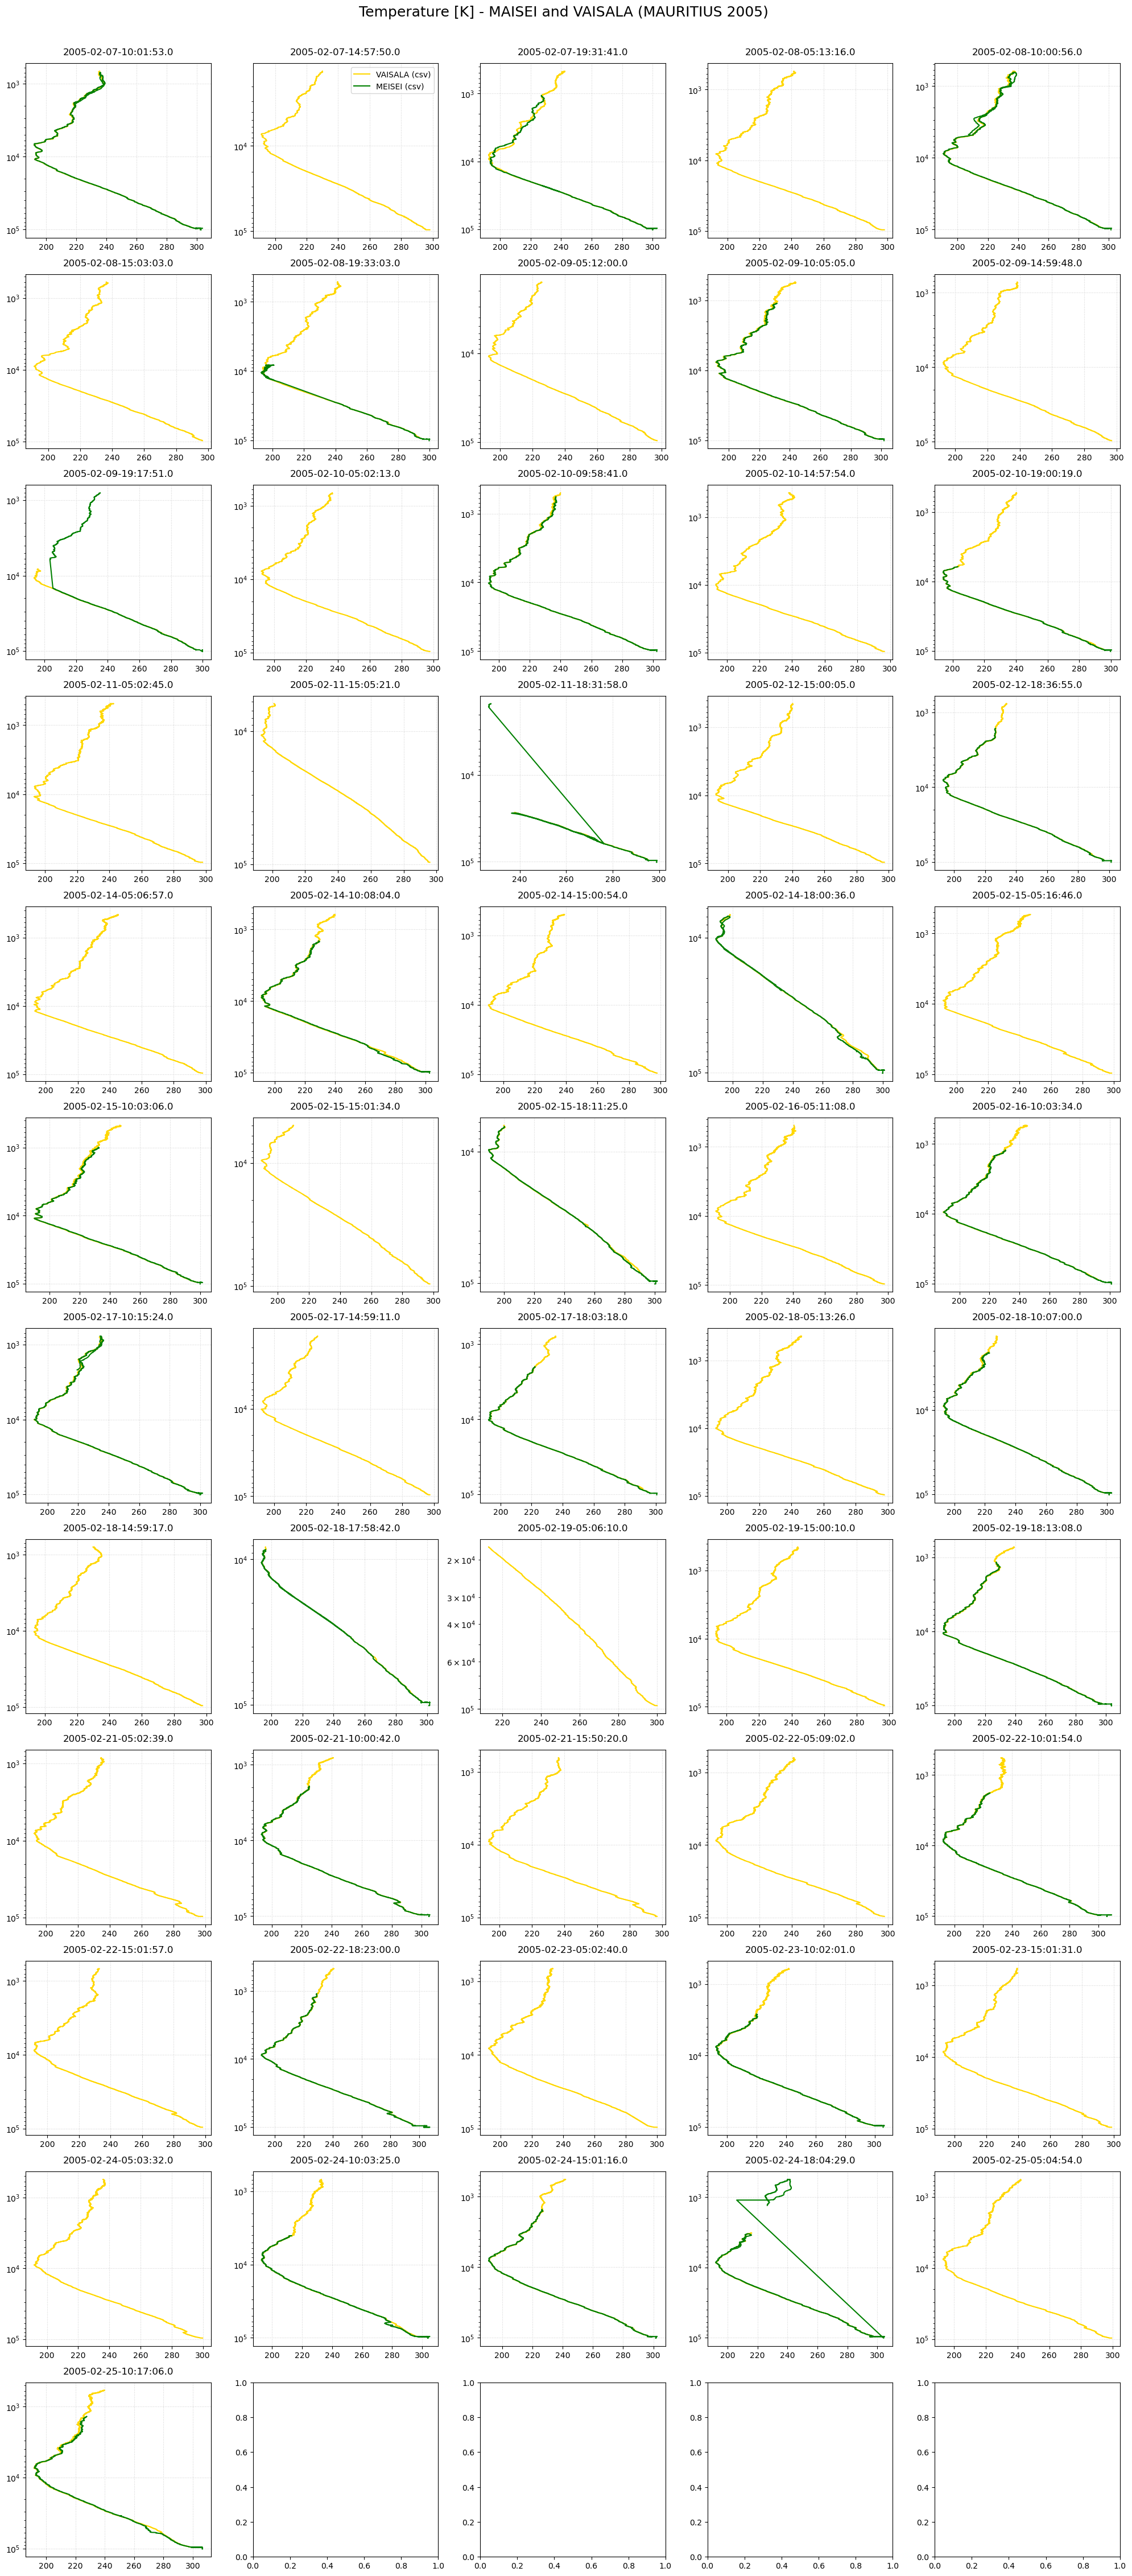

In [11]:
fig, axes = plt.subplots(12, 5, figsize=(20, 45) )
# flattening axes 
axes= axes.flatten()

if not os.path.isdir('MAURITIUS_2005_ANALYSIS/plots/'):
    os.mkdir('MAURITIUS_2005_ANALYSIS/plots/')
    
var = 126 
for ind,t in enumerate(all_ts):
    date = t[0:10]
    hour = t.split('T')[1][0:10]
    
    mei = 'MAURITIUS_2005_ANALYSIS/' + t + '_MEISEI.csv'
    vai = 'MAURITIUS_2005_ANALYSIS/' + t + '_VAISALA.csv'
    ax = axes[ind]
    df_mei = extract_data_ts(mei, var=var)
    df_vai = extract_data_ts(vai, var=var)
    
    f = make_profile(df_vai, df_mei, ax, ind, var=126 , date= date, hour=hour)
    
#fig.suptitle("Temperature [K] - MAISEI and VAISALA (MAURITIUS 2005) ", fontsize=18, y=1.005)
fig.suptitle("Temperature [K] - MAISEI and VAISALA (MAURITIUS 2005) ", fontsize=18, y=1.005)

plt.tight_layout() # -> then set title offset y=0.885 
plt.show()
plt.savefig('MAURITIUS_2005_ANALYSIS/plots/Temperature_profiles', dpi=150)
plt.close()

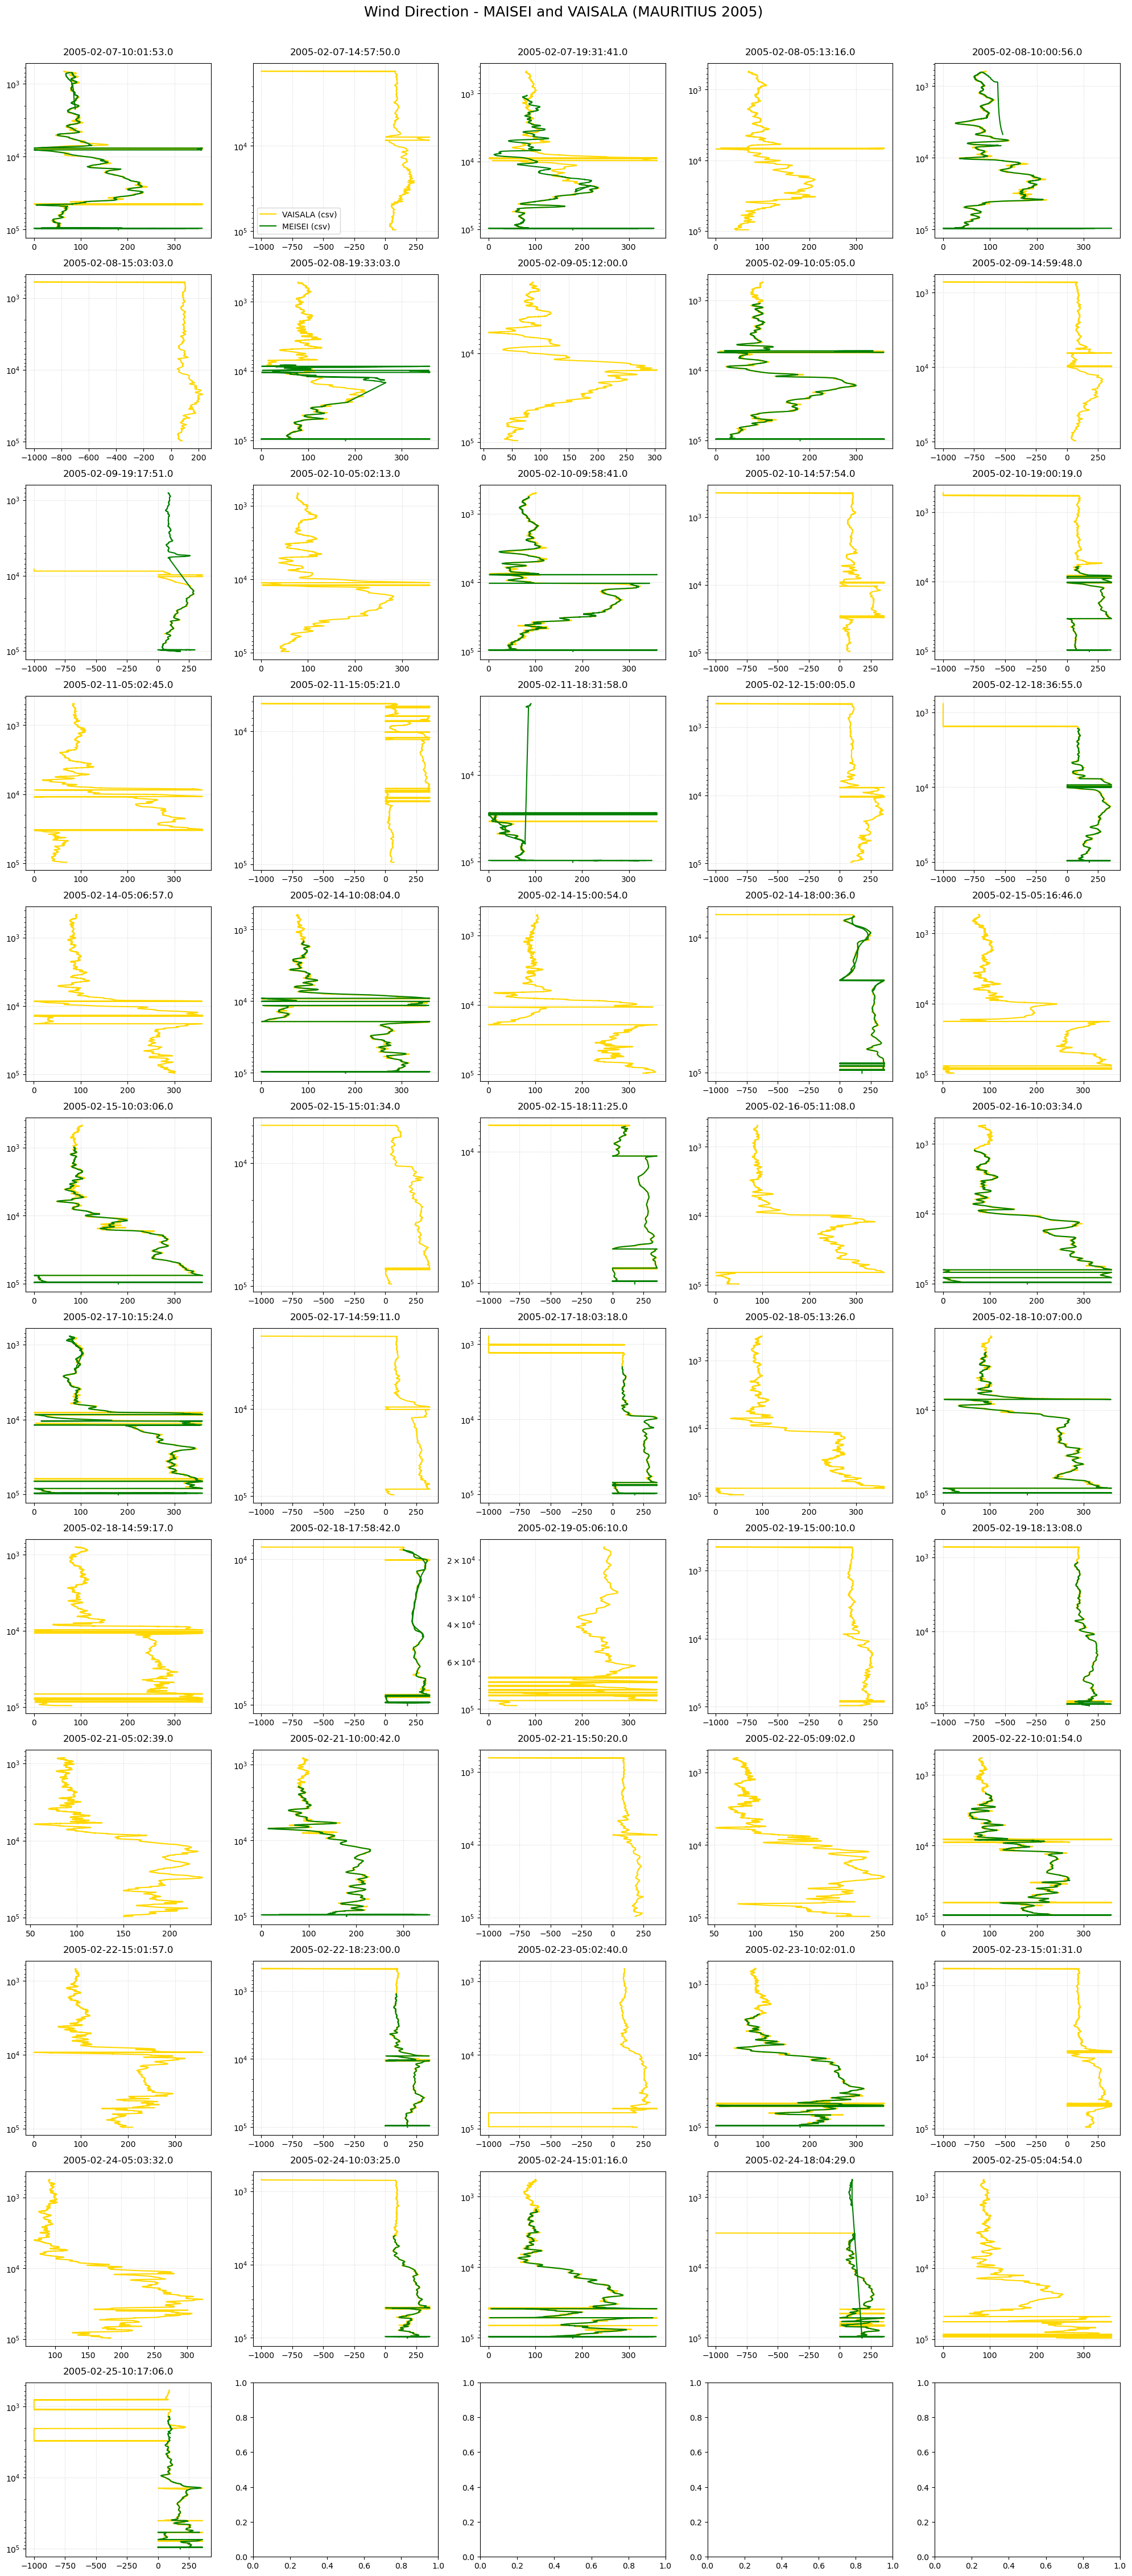

In [12]:
fig, axes = plt.subplots(12, 5, figsize=(20, 45) )
# flattening axes 
axes= axes.flatten()

var = 106 
for ind,t in enumerate(all_ts):
    date = t[0:10]
    hour = t.split('T')[1][0:10]
    
    mei = 'MAURITIUS_2005_ANALYSIS/' + t + '_MEISEI.csv'
    vai = 'MAURITIUS_2005_ANALYSIS/' + t + '_VAISALA.csv'
    ax = axes[ind]
    df_mei = extract_data_ts(mei, var=var)
    df_vai = extract_data_ts(vai, var=var)
    
    f = make_profile(df_vai, df_mei, ax, ind, var=var , date= date, hour=hour)
    
fig.suptitle("Wind Direction - MAISEI and VAISALA (MAURITIUS 2005) ", fontsize=18, y=1.005)
plt.tight_layout() # -> then set title offset y=0.885 
plt.savefig('MAURITIUS_2005_ANALYSIS/WindDirection_profiles', dpi=150)



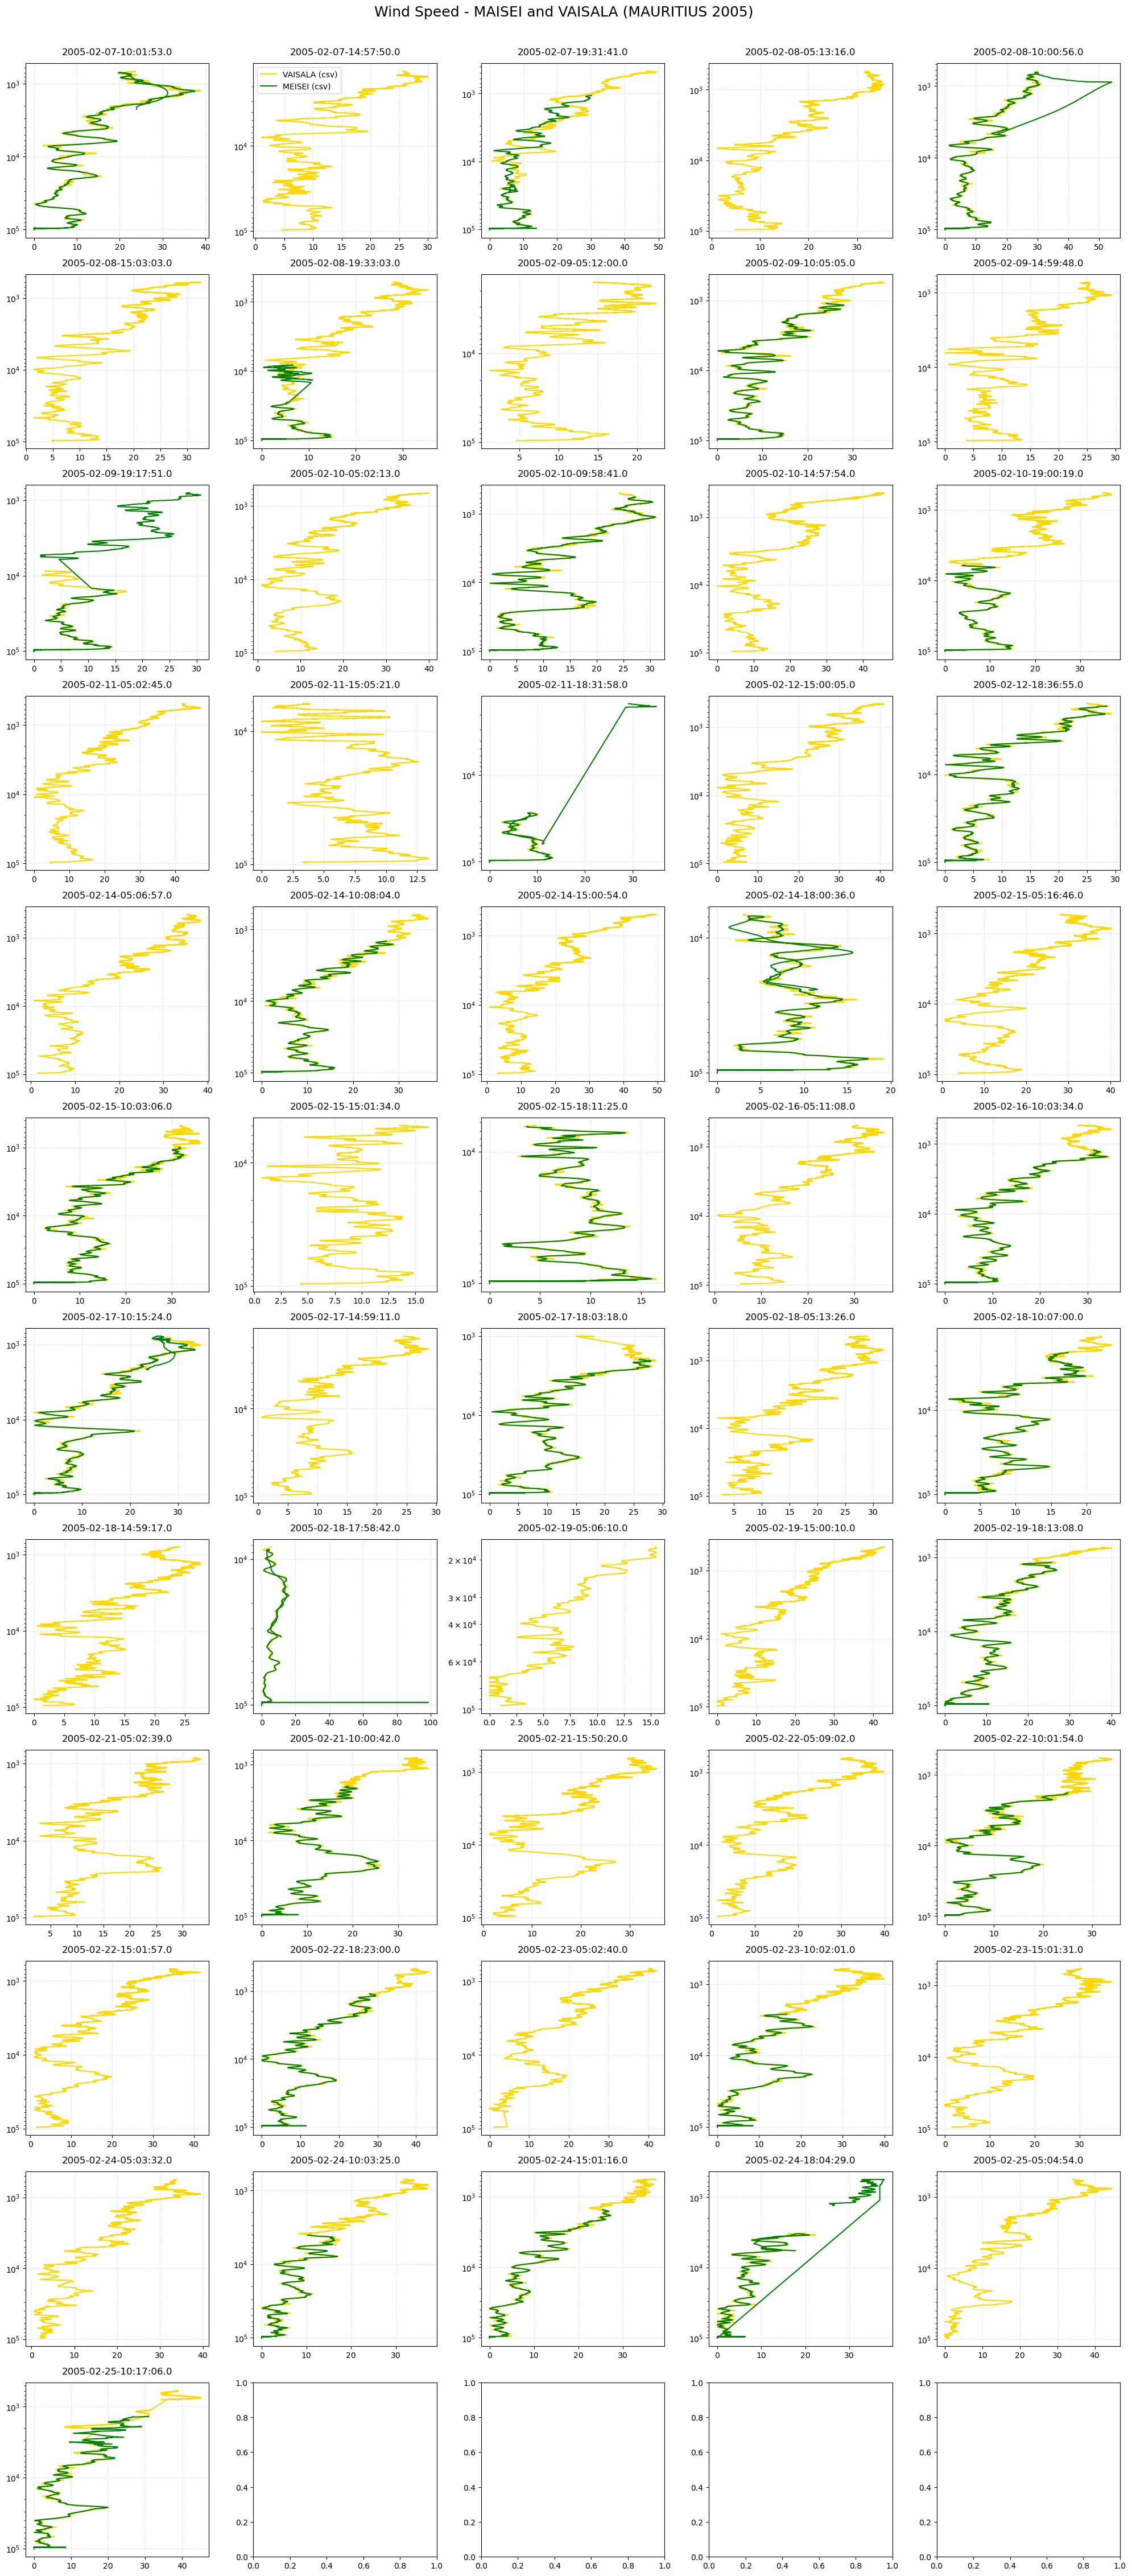

In [13]:
fig, axes = plt.subplots(12, 5, figsize=(20, 45) )
# flattening axes 
axes= axes.flatten()

var = 107 
for ind,t in enumerate(all_ts):
    date = t[0:10]
    hour = t.split('T')[1][0:10]
    
    mei = 'MAURITIUS_2005_ANALYSIS/' + t + '_MEISEI.csv'
    vai = 'MAURITIUS_2005_ANALYSIS/' + t + '_VAISALA.csv'
    ax = axes[ind]
    df_mei = extract_data_ts(mei, var=var)
    df_vai = extract_data_ts(vai, var=var)
    
    f = make_profile(df_vai, df_mei, ax, ind, var=var , date= date, hour=hour)
    
fig.suptitle("Wind Speed - MAISEI and VAISALA (MAURITIUS 2005) ", fontsize=18, y=1.005)
plt.tight_layout() # -> then set title offset y=0.885 
plt.savefig('MAURITIUS_2005_ANALYSIS/WindSpeed_profiles', dpi=150)


In [14]:
#df_red = df_meisei.loc[ (df_meisei['date'] == pd.Timestamp('2005-02-07')) ] 
#df_red = df_meisei.loc[ (df_meisei['observed_variable'] == 126 ) ] 


In [15]:
#f, vai, mei =  make_profile(df_vaisala, df_meisei, var=126 , date= '2005-02-07', hour_m = 10 , hour_v = 14)

In [16]:
#f, vai, mei =  make_profile(df_vaisala, df_meisei, var=126 , date= '2005-02-07', hour_m = 11 , hour_v = 14)

### PLOT FOR PAPER/DOC

In [17]:
digitized_dir = '/users/staff/uvoggenberger/scratch/new_digi_csv'

/tmp/ipykernel_898933/3159586391.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  vai_digi = pd.read_csv(  digitized_dir + '/vaisala.csv' , delimiter='; ', decimal=',', names=['ta', 'z'])
/tmp/ipykernel_898933/3159586391.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mai_digi = pd.read_csv(  digitized_dir + '/meisei.csv', delimiter='; ', decimal=',', names=['ta', 'z'])
/tmp/ipykernel_898933/3159586391.py:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can

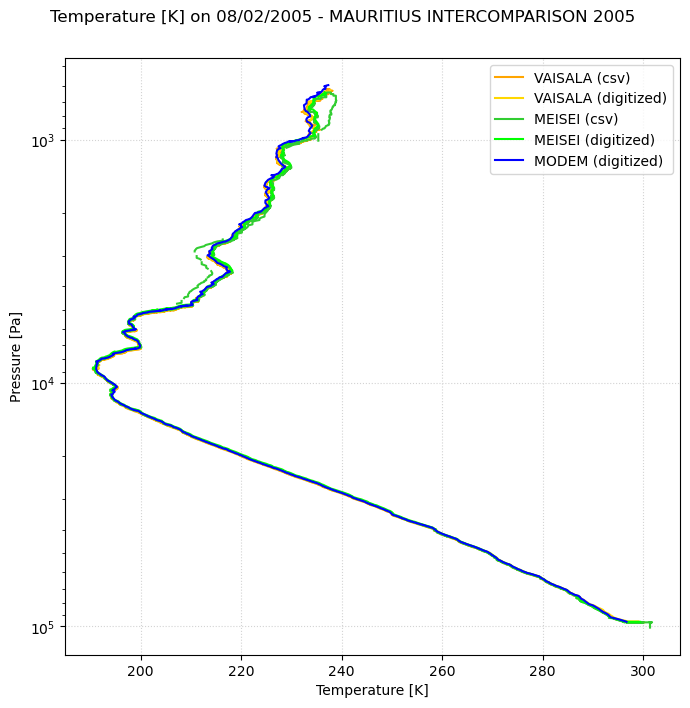

In [18]:
fig, ax = plt.subplots(1,1, figsize=(7, 7) )

    
var = 126 


df_mei_csv = pd.read_csv('MAURITIUS_2005_ANALYSIS/2005-02-08T10:00:56.000000000_MEISEI.csv', sep='\t')
df_vai_csv = pd.read_csv('MAURITIUS_2005_ANALYSIS/2005-02-08T10:00:56.000000000_VAISALA.csv', sep='\t')

#2005-02-08T15:03:03.000000000_MEISEI.csv

#df_mei_csv = pd.read_csv('MAURITIUS_2005_ANALYSIS/2005-02-08T15:03:03.000000000_MEISEI.csv', sep='\t')
#df_vai_csv = pd.read_csv('MAURITIUS_2005_ANALYSIS/2005-02-08T15:03:03.000000000_VAISALA.csv', sep='\t')

df_mei_csv_red = df_mei_csv.loc[ (df_mei_csv['observed_variable'] ==  var) ]
df_vai_csv_red = df_vai_csv.loc[ (df_vai_csv['observed_variable'] ==  var) ]
        
date = '08/02/2005'
hour = '10:00'


vai_digi = pd.read_csv(  digitized_dir + '/vaisala.csv' , delimiter='; ', decimal=',', names=['ta', 'z'])
mai_digi = pd.read_csv(  digitized_dir + '/meisei.csv', delimiter='; ', decimal=',', names=['ta', 'z'])
mod_digi = pd.read_csv(  digitized_dir + '/modem.csv', delimiter='; ', decimal=',', names=['ta', 'z'])

for d in [vai_digi, mai_digi, mod_digi]:
    d['z'] = d['z']*100
    d['ta'] = d['ta']+273.15
mod_digi = mod_digi.loc[mod_digi.ta > 191]

# harvested
ax.plot(df_vai_csv_red.observation_value, df_vai_csv_red.z_coordinate , label = 'VAISALA (csv)', color = 'orange')
ax.plot(vai_digi.ta, vai_digi.z , label = 'VAISALA (digitized)', color = 'gold')

ax.plot(df_mei_csv_red.observation_value, df_mei_csv_red.z_coordinate , label = 'MEISEI (csv)', color = 'limegreen')
ax.plot(mai_digi.ta, mai_digi.z , label = 'MEISEI (digitized)', color = 'lime')

# digitized
ax.plot(mod_digi.ta, mod_digi.z , label = 'MODEM (digitized)', color = 'blue')

ax.set_ylabel('Pressure [Pa]')
ax.set_xlabel('Temperature [K]')

ax.grid(ls=':' , color = 'lightgray')
ax.legend()
ax.set_yscale('log')
ax.invert_yaxis()

    

fig.suptitle("Temperature [K] on " + date + " - MAURITIUS INTERCOMPARISON 2005 ", fontsize=12, y=1.005)
plt.tight_layout() # -> then set title offset y=0.885 
plt.show()
#plt.savefig('MAURITIUS_2005_ANALYSIS/plots/Temperature_profiles', dpi=150)
#plt.close()


/tmp/ipykernel_898933/2267719249.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  vai_digi = pd.read_csv(  digitized_dir + '/vaisala.csv' , delimiter='; ', decimal=',', names=['observation_value', 'z_coordinate'])
/tmp/ipykernel_898933/2267719249.py:32: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mai_digi = pd.read_csv(  digitized_dir + '/meisei.csv', delimiter='; ', decimal=',', names=['observation_value', 'z_coordinate'])
/tmp/ipykernel_898933/2267719249.py:33: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and dif

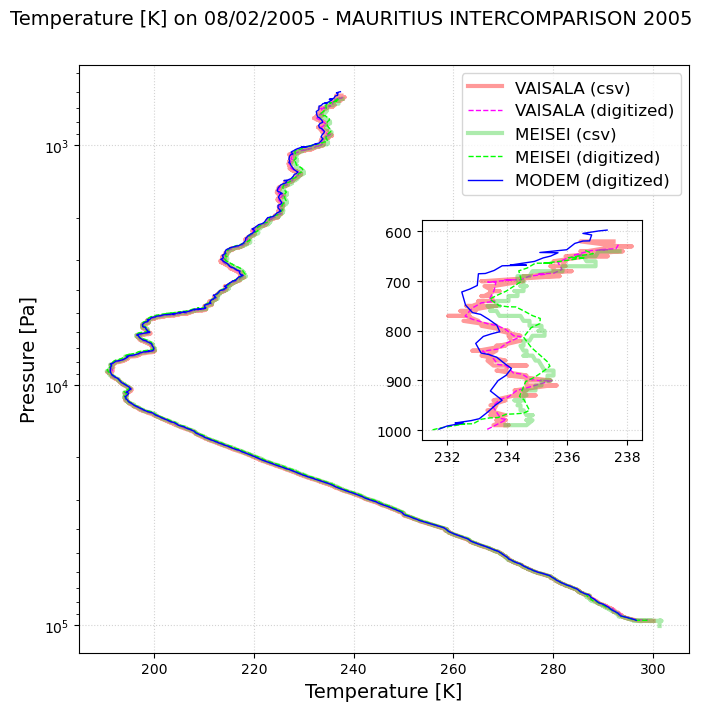

'\nfig, axes = plt.subplots(2,2)\n\nfor ax in axes.flat:\n    ax.plot(np.arange(11),np.arange(11))\n\n    ins = ax.inset_axes([0.7,0.7,0.2,0.2])\n'

In [69]:
### Cleaned MEISEI
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1,1, figsize=(7, 7) )

    
var = 126 


df_mei_csv = pd.read_csv('MAURITIUS_2005_ANALYSIS/2005-02-08T10:00:56.000000000_MEISEI.csv', sep='\t')
df_vai_csv = pd.read_csv('MAURITIUS_2005_ANALYSIS/2005-02-08T10:00:56.000000000_VAISALA.csv', sep='\t')

#2005-02-08T15:03:03.000000000_MEISEI.csv

#df_mei_csv = pd.read_csv('MAURITIUS_2005_ANALYSIS/2005-02-08T15:03:03.000000000_MEISEI.csv', sep='\t')
#df_vai_csv = pd.read_csv('MAURITIUS_2005_ANALYSIS/2005-02-08T15:03:03.000000000_VAISALA.csv', sep='\t')
# st = pd.Timestamp( '2005-02-08 11:27:06') -> index 27240

df_mei_csv_red = df_mei_csv.loc[ (df_mei_csv['observed_variable'] ==  var) ]
df_mei_csv_red = df_mei_csv_red.reset_index()
df_mei_csv_red = df_mei_csv_red[:6800]

df_vai_csv_red = df_vai_csv.loc[ (df_vai_csv['observed_variable'] ==  var) ]
        
date = '08/02/2005'
hour = '10:00'

# fontsize
fs = 12

vai_digi = pd.read_csv(  digitized_dir + '/vaisala.csv' , delimiter='; ', decimal=',', names=['observation_value', 'z_coordinate'])
mai_digi = pd.read_csv(  digitized_dir + '/meisei.csv', delimiter='; ', decimal=',', names=['observation_value', 'z_coordinate'])
mod_digi = pd.read_csv(  digitized_dir + '/modem.csv', delimiter='; ', decimal=',', names=['observation_value', 'z_coordinate'])

# fix values from digitized data 
for d in [vai_digi, mai_digi, mod_digi]:
    d['z_coordinate'] = d['z_coordinate']*100
    d['observation_value'] = d['observation_value']+273.15
mod_digi = mod_digi.loc[mod_digi.observation_value > 191]


dfs = [df_vai_csv_red, vai_digi, df_mei_csv_red ,mai_digi, mod_digi]
colors = ['red','magenta','limegreen','lime','blue']
styles = ['-','--','-','--','-']
widths = [3,1,3,1,1]
alphas = [0.4,1,0.4,1,1]
labels = ['VAISALA (csv)', 'VAISALA (digitized)','MEISEI (csv)', 'MEISEI (digitized)', 'MODEM (digitized)' ]

for df, color, label, alpha, wid, style in zip( dfs, colors, labels, alphas, widths, styles ):
    ax.plot(df.observation_value, df.z_coordinate , label = label, color = color, lw=wid, ls=style, alpha=alpha)

    

'''
ax.plot(df_vai_csv_red.observation_value, df_vai_csv_red.z_coordinate , label = 'VAISALA (csv)', color = 'red', lw = 3, alpha=0.4)
ax.plot(vai_digi.observation_value, vai_digi.z_coordinate , label = 'VAISALA (digitized)', color = 'magenta', ls='--')
ax.plot(df_mei_csv_red.observation_value, df_mei_csv_red.z_coordinate , label = 'MEISEI (csv)', color = 'limegreen', lw = 3, alpha=0.4)
ax.plot(mai_digi.observation_value, mai_digi.z_coordinate , label = 'MEISEI (digitized)', color = 'lime', ls='--')
ax.plot(mod_digi.observation_value, mod_digi.z_coordinate , label = 'MODEM (digitized)', color = 'blue')
'''

ax.set_ylabel('Pressure [Pa]', fontsize=fs+2)
ax.set_xlabel('Temperature [K]', fontsize=fs+2)

ax.grid(ls=':' , color = 'lightgray')
ax.legend( fontsize=fs)
ax.set_yscale('log')
ax.invert_yaxis()

    
axins = inset_axes(ax, width=2.2, height=2.2,
                  bbox_to_anchor=(.55, .35, .65, .5),
                   bbox_transform=ax.transAxes, loc=3
                  )

for d in dfs:
    d = d.loc[d.z_coordinate > 5000]

for df, color, label, alpha, wid, style in zip( dfs, colors, labels, alphas, widths, styles ):
    df = df.loc[df.z_coordinate < 1000]
    axins.plot(df.observation_value, df.z_coordinate , label = label, color = color, lw=wid, ls=style, alpha=alpha)
axins.grid(ls=':' , color = 'lightgray')

axins.set_yscale('linear')
axins.invert_yaxis()
#axins.set_yticks([600,700,800,900,1000,2000])
#axins.set_yticklabels([600,700,800,900,1000,2000])

fig.suptitle("Temperature [K] on " + date + " - MAURITIUS INTERCOMPARISON 2005 ", fontsize=fs+2, y=1.01)
plt.tight_layout() # -> then set title offset y=0.885 
plt.show()
#plt.savefig('MAURITIUS_2005_ANALYSIS/plots/Temperature_profiles', dpi=150)
#plt.close()


'''
fig, axes = plt.subplots(2,2)

for ax in axes.flat:
    ax.plot(np.arange(11),np.arange(11))

    ins = ax.inset_axes([0.7,0.7,0.2,0.2])
'''

In [63]:
df_mei_csv_red[:10]

index  Unnamed: 0            date_time  z_coordinate  z_coordinate_type  \
0  0      67336       2005-02-08 09:27:05  101090.0      1                   
1  4      67340       2005-02-08 09:27:06  101090.0      1                   
2  8      67344       2005-02-08 09:27:07  101090.0      1                   
3  12     67348       2005-02-08 09:27:09  101090.0      1                   
4  16     67352       2005-02-08 09:27:10  101090.0      1                   
5  20     67356       2005-02-08 09:27:11  101090.0      1                   
6  24     67360       2005-02-08 09:27:13  96280.0       1                   
7  28     67364       2005-02-08 09:27:15  96270.0       1                   
8  32     67368       2005-02-08 09:27:16  96260.0       1                   
9  36     67372       2005-02-08 09:27:17  96250.0       1                   

   observed_variable  observation_value source_id  hour        date  
0  126                301.35             MEISEI    9     2005-02-08  
1  126                301.35             MEISEI    9     2005-02-08  
2  126                301.35             MEISEI    9     2005-02-08  
3  126                301.35             MEISEI    9     2005-02-08  
4  126                301.35             MEISEI    9     2005-02-08  
5  126                301.35             MEISEI    9     2005-02-08  
6  126                301.35             MEISEI    9     2005-02-08  
7  126                301.35             MEISEI    9     2005-02-08  
8  126                301.35             MEISEI    9     2005-02-08  
9  126                301.35             MEISEI    9     2005-02-08